In [21]:
import pandas as pd
import os
from sklearn.preprocessing import MultiLabelBinarizer
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image

# Load the CSV file
df = pd.read_csv("restaurant_photos_filtered.csv")

# Drop rows with missing 'photo_id' values
# df.dropna(subset=['photo_id'], inplace=True)

# Encode categories column
mlb = MultiLabelBinarizer()
categories_encoded = mlb.fit_transform(df['categories'].apply(eval))

# Define a custom dataset class
class CustomDataset:
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 1]) + ".jpg"  # Assuming images are in .jpg format
        image = Image.open(img_name)
        label = categories_encoded[idx]  # Use the encoded categories
        label = label.astype(float)  # Convert to float for better compatibility
        
        if self.transform:
            image = self.transform(image)

        return image, label

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Initialize custom dataset
dataset = CustomDataset(dataframe=df, root_dir="yelp_photos/photos", transform=transform)

# Initialize data loader
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [34]:
df.head()

,business_id,photo_id,caption,label,categories
0,6VDSx-ghQwbYvMaS0fz9xw,yN_gr5fgvPvNenF3gzZQ9Q,Bar area,inside,"['American (New)', 'Nightlife', 'Bars', 'Beer'..."
1,XkQadWW9bUR855KvPZBNUw,SV05oM90MYKraN8glLY6Tw,NaN,food,"['Breweries', 'Nightlife', 'Restaurants', 'Foo..."
2,9iSoPNBV54dj6L0rxO4RWw,2rW621UDMRvM1i307MJfHQ,Sushi preparation area with a beautiful artwor...,inside,"['Desserts', 'Soup', 'Food', 'Restaurants', 'S..."
3,5Mxa0q08Kn6ZVbmbsLcZDw,fpiC6XeIk_wtVLVd3f12Jg,Chicken Parmigiania,food,"['Food', 'Caterers', 'Restaurants', 'Event Pla..."
4,egDsfkn6ZYrYRnlGe4I94g,1swLv3rYIeHhRE4c_VZD7Q,NaN,drink,"['Food', 'Restaurants', 'Sushi Bars', 'Japanes..."


In [30]:
categories_encoded[0].size

358

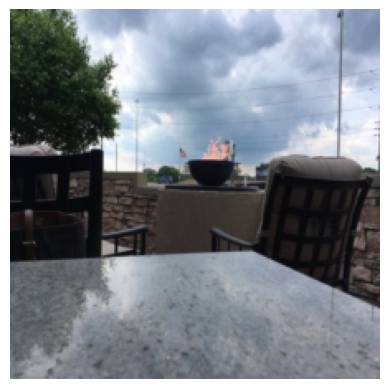

Encoded vector: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 

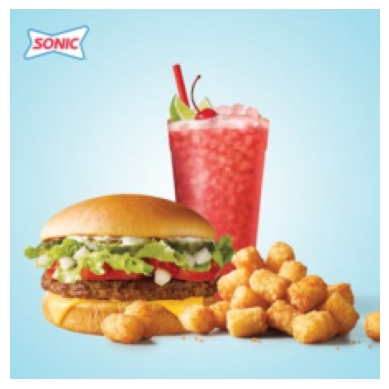

Encoded vector: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Print sample images, encoded vectors, and labels
num_samples = 2  # Number of samples to print
sample_count = 0  # Initialize sample counter

for images, labels in data_loader:
    for i in range(len(images)):
        # Display image
        plt.imshow(np.transpose(images[i], (1, 2, 0)))  # Transpose image tensor to (height, width, channels) for display
        plt.axis('off')
        plt.show()
        
        # Print encoded vector
        print("Encoded vector:", labels[i])
        
        # Decode labels
        decoded_labels = mlb.inverse_transform(np.expand_dims(labels[i], axis=0))
        print("Decode Labels:", decoded_labels)
        
        print("-" * 50)
        
        sample_count += 1
        if sample_count >= num_samples:
            break
            
    if sample_count >= num_samples:
        break
